<div dir="rtl">

# تحلیل جریان‌های IP

<div dir="rtl">

## مقدمه
در این نوتبوک، سعی خواهیم کرد جریان‌های ترافیک شبکه IP را تحلیل کنیم تا پروتکل لایه کاربردی (برنامه خاص) مانند فیسبوک، یوتیوب و اینستاگرام را پیش‌بینی کنیم.

داده‌های مورد استفاده را می‌توانید از [اینجا](https://www.kaggle.com/jsrojas/ip-network-traffic-flows-labeled-with-87-apps) دریافت کنید. این مجموعه داده شامل 87 ویژگی است. هر نمونه حاوی اطلاعات یک جریان IP تولید شده توسط یک دستگاه شبکه است، مانند آدرس‌های IP مبدأ و مقصد، پورت‌ها، زمان‌های بین ورودی و پروتکل لایه 7 (برنامه) مورد استفاده در آن جریان به عنوان کلاسی که قصد پیش‌بینی آن را داریم.

<div dir="rtl">

## فهرست مطالب

I. [تحلیل اکتشافی](#Exploratory-analysis)<br>
II. [پیش‌پردازش داده‌ها](#Data-preprocessing)<br>
III. [مدل‌سازی داده‌ها](#Data-Modeling)<br>
IV. [ارزیابی نتایج](#Results-Evaluation)<br>
V. [نتیجه‌گیری](#Conclusion)<br>

<div dir="rtl">

## <a class="anchor" id="تحلیل اکتشافی">I. تحلیل اکتشافی</a>

<div dir="rtl">

### بارگذاری کتابخانه‌های لازم

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

'3.1.0'

<div dir="rtl">

### بارگذاری مجموعه‌داده‌ها

In [ ]:
df = pd.read_csv('Dataset-Unicauca-Version2-87Atts.csv', delimiter=',',)
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 3577296 rows and 87 columns


In [ ]:
pd.set_option('display.max_columns', 1000)
df.head()

,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets,Fwd.Packet.Length.Max,Fwd.Packet.Length.Min,Fwd.Packet.Length.Mean,Fwd.Packet.Length.Std,Bwd.Packet.Length.Max,Bwd.Packet.Length.Min,Bwd.Packet.Length.Mean,Bwd.Packet.Length.Std,Flow.Bytes.s,Flow.Packets.s,Flow.IAT.Mean,Flow.IAT.Std,Flow.IAT.Max,Flow.IAT.Min,Fwd.IAT.Total,Fwd.IAT.Mean,Fwd.IAT.Std,Fwd.IAT.Max,Fwd.IAT.Min,Bwd.IAT.Total,Bwd.IAT.Mean,Bwd.IAT.Std,Bwd.IAT.Max,Bwd.IAT.Min,Fwd.PSH.Flags,Bwd.PSH.Flags,Fwd.URG.Flags,Bwd.URG.Flags,Fwd.Header.Length,Bwd.Header.Length,Fwd.Packets.s,Bwd.Packets.s,Min.Packet.Length,Max.Packet.Length,Packet.Length.Mean,Packet.Length.Std,Packet.Length.Variance,FIN.Flag.Count,SYN.Flag.Count,RST.Flag.Count,PSH.Flag.Count,ACK.Flag.Count,URG.Flag.Count,CWE.Flag.Count,ECE.Flag.Count,Down.Up.Ratio,Average.Packet.Size,Avg.Fwd.Segment.Size,Avg.Bwd.Segment.Size,Fwd.Header.Length.1,Fwd.Avg.Bytes.Bulk,Fwd.Avg.Packets.Bulk,Fwd.Avg.Bulk.Rate,Bwd.Avg.Bytes.Bulk,Bwd.Avg.Packets.Bulk,Bwd.Avg.Bulk.Rate,Subflow.Fwd.Packets,Subflow.Fwd.Bytes,Subflow.Bwd.Packets,Subflow.Bwd.Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
0,172.19.1.46-10.200.7.7-52422-3128-6,172.19.1.46,52422,10.200.7.7,3128,6,26/04/201711:11:17,45523,22,55,132,110414.0,6,6,6.000000,0.000000,4380,1187,2007.527273,768.481689,2.428355e+06,1.691453e+03,598.986842,816.061346,3880.0,1,45523.0,2167.761905,1319.384512,5988.0,698.0,41178.0,762.555556,1230.348220,5133.0,1.0,0,0,0,0,440,1100,4.832722e+02,1208.180480,6,4380,1417.333333,1121.579194,1.257940e+06,0,0,0,0,1,0,0,0,2,1435.74026,6.000000,2007.527273,440,0,0,0,0,0,0,22,132,55,110414,256,490,21,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
1,172.19.1.46-10.200.7.7-52422-3128-6,10.200.7.7,3128,172.19.1.46,52422,6,26/04/201711:11:17,1,2,0,12,0.0,6,6,6.000000,0.000000,0,0,0.000000,0.000000,1.200000e+07,2.000000e+06,1.000000,0.000000,1.0,1,1.0,1.000000,0.000000,1.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0,0,0,0,40,0,2.000000e+06,0.000000,6,6,6.000000,0.000000,0.000000e+00,0,0,0,0,1,1,0,0,0,9.00000,6.000000,0.000000,40,0,0,0,0,0,0,2,12,0,0,490,-1,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
2,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,1,3,0,674,0.0,337,0,224.666667,194.567041,0,0,0.000000,0.000000,6.740000e+08,3.000000e+06,0.500000,0.707107,1.0,0,1.0,0.500000,0.707107,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1,0,0,0,96,0,3.000000e+06,0.000000,0,337,252.750000,168.500000,2.839225e+04,0,1,0,0,1,0,0,0,0,337.00000,224.666667,0.000000,96,0,0,0,0,0,0,3,674,0,0,888,-1,1,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
3,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,217,1,3,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,1.843318e+04,72.333333,62.660461,110.0,0,0.0,0.000000,0.000000,0.0,0.0,107.0,53.500000,75.660426,107.0,0.0,0,0,0,0,32,96,4.608295e+03,13824.884793,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,1,0,0,3,0.00000,0.000000,0.000000,32,0,0,0,0,0,0,1,0,3,0,888,490,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
4,192.168.72.43-10.200.7.7-55961-3128-6,192.168.72.43,55961,10.200.7.7,3128,6,26/04/201711:11:17,78068,5,0,1076,0.0,529,6,215.200000,286.458898,0,0,0.000000,0.000000,1.378286e+04,6.404673e+01,19517.000000,25758.502350,54313.0,0,78068.0,19517.000000,25758.502350,54313.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1,0,0,0,100,0,6.404673e+01,0.000000,6,529,267.500000,286.458898,8.205870e+04,0,1,0,0,1,0,0,0,0,321.00000,215.200000,0.000000,100,0,0,0,0,0,0,5,1076,0,0,253,-1,4,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY


In [ ]:
df.describe()

,Source.Port,Destination.Port,Protocol,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets,Fwd.Packet.Length.Max,Fwd.Packet.Length.Min,Fwd.Packet.Length.Mean,Fwd.Packet.Length.Std,Bwd.Packet.Length.Max,Bwd.Packet.Length.Min,Bwd.Packet.Length.Mean,Bwd.Packet.Length.Std,Flow.Bytes.s,Flow.Packets.s,Flow.IAT.Mean,Flow.IAT.Std,Flow.IAT.Max,Flow.IAT.Min,Fwd.IAT.Total,Fwd.IAT.Mean,Fwd.IAT.Std,Fwd.IAT.Max,Fwd.IAT.Min,Bwd.IAT.Total,Bwd.IAT.Mean,Bwd.IAT.Std,Bwd.IAT.Max,Bwd.IAT.Min,Fwd.PSH.Flags,Bwd.PSH.Flags,Fwd.URG.Flags,Bwd.URG.Flags,Fwd.Header.Length,Bwd.Header.Length,Fwd.Packets.s,Bwd.Packets.s,Min.Packet.Length,Max.Packet.Length,Packet.Length.Mean,Packet.Length.Std,Packet.Length.Variance,FIN.Flag.Count,SYN.Flag.Count,RST.Flag.Count,PSH.Flag.Count,ACK.Flag.Count,URG.Flag.Count,CWE.Flag.Count,ECE.Flag.Count,Down.Up.Ratio,Average.Packet.Size,Avg.Fwd.Segment.Size,Avg.Bwd.Segment.Size,Fwd.Header.Length.1,Fwd.Avg.Bytes.Bulk,Fwd.Avg.Packets.Bulk,Fwd.Avg.Bulk.Rate,Bwd.Avg.Bytes.Bulk,Bwd.Avg.Packets.Bulk,Bwd.Avg.Bulk.Rate,Subflow.Fwd.Packets,Subflow.Fwd.Bytes,Subflow.Bwd.Packets,Subflow.Bwd.Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,L7Protocol
count,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3577296.0,3577296.0,3577296.0,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3577296.0,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3577296.0,3577296.0,3577296.0,3577296.0,3577296.0,3577296.0,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06
mean,3.799938e+04,1.204246e+04,6.005508e+00,2.544247e+07,6.237799e+01,6.534083e+01,4.683323e+04,8.445742e+04,5.123645e+02,9.340408e+00,1.149212e+02,1.520501e+02,1.103231e+03,1.113491e+01,2.547845e+02,2.898878e+02,4.048709e+06,8.896338e+04,1.422201e+06,3.365395e+06,1.285020e+07,8.870201e+04,2.418796e+07,3.124467e+06,3.649620e+06,1.209624e+07,1.271532e+06,2.110451e+07,2.476877e+06,2.932460e+06,9.830803e+06,8.889991e+05,1.720414e-01,0.0,0.0,0.0,1.653339e+03,1.743621e+03,7.705816e+04,1.190522e+04,3.043745e+00,1.333250e+03,1.988191e+02,3.035190e+02,2.792736e+05,7.037159e-03,1.720414e-01,6.655865e-04,4.058210e-01,5.995705e-01,2.773847e-01,0.0,6.566412e-04,9.085471e-01,2.075630e+02,1.149212e+02,2.547845e+02,1.653339e+03,0.0,0.0,0.0,0.0,0.0,0.0,6.237799e+01,4.683323e+04,6.534083e+01,8.445742e+04,8.984691e+03,2.123489e+03,4.503535e+01,2.569738e+01,2.981990e+05,1.836406e+05,5.229372e+05,1.676336e+05,8.524211e+06,1.370991e+06,9.743845e+06,7.252097e+06,1.029508e+02
std,2.201713e+04,2.044916e+04,3.274574e-01,4.014430e+07,1.094086e+03,1.108092e+03,1.816196e+06,2.124319e+06,1.039319e+03,8.299983e+01,2.464707e+02,2.404702e+02,2.352374e+03,1.055422e+02,5.060731e+02,4.853004e+02,7.551040e+07,4.027620e+05,3.550414e+06,6.260959e+06,2.076518e+07,1.605272e+06,3.962563e+07,8.358652e+06,7.390979e+06,2.049180e+07,7.279117e+06,3.862634e+07,7.578111e+06,6.666650e+06,1.883521e+07,6.231082e+06,3.774165e-01,0.0,0.0,0.0,3.008890e+04,3.039190e+04,3.683153e+05,1.080206e+05,4.145472e+01,2.453395e+03,3.327427e+02,4.326083e+02,7.258608e+05,8.359210e-02,3.774165e-01,2.579038e-02,4.910503e-01,4.899855e-01,4.477080e-01,0.0,2.561660e-02,1.269945e

In [ ]:
print(f"Number of NaNs is {(df.isna().sum() > 0).sum()}")

Number of NaNs is 0


In [ ]:
print(f"Number of classes we will try to predict is {len(df['L7Protocol'].unique())}")

Number of classes we will try to predict is 78


In [ ]:
connction_flow_count = df.groupby('Flow.ID').apply(lambda flow: len(flow))

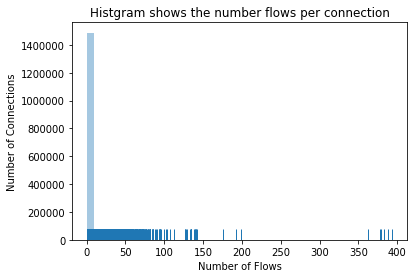

In [ ]:
ax = sns.distplot(connction_flow_count, kde=False, rug=True, label="S");
ax.set(xlabel='Number of Flows', ylabel='Number of Connections', title='Histgram shows the number flows per connection');
plt.show();

<div dir="rtl">

* می‌بینیم که برخی ارتباطات با حجم بالایی از جریان‌ها وجود دارند

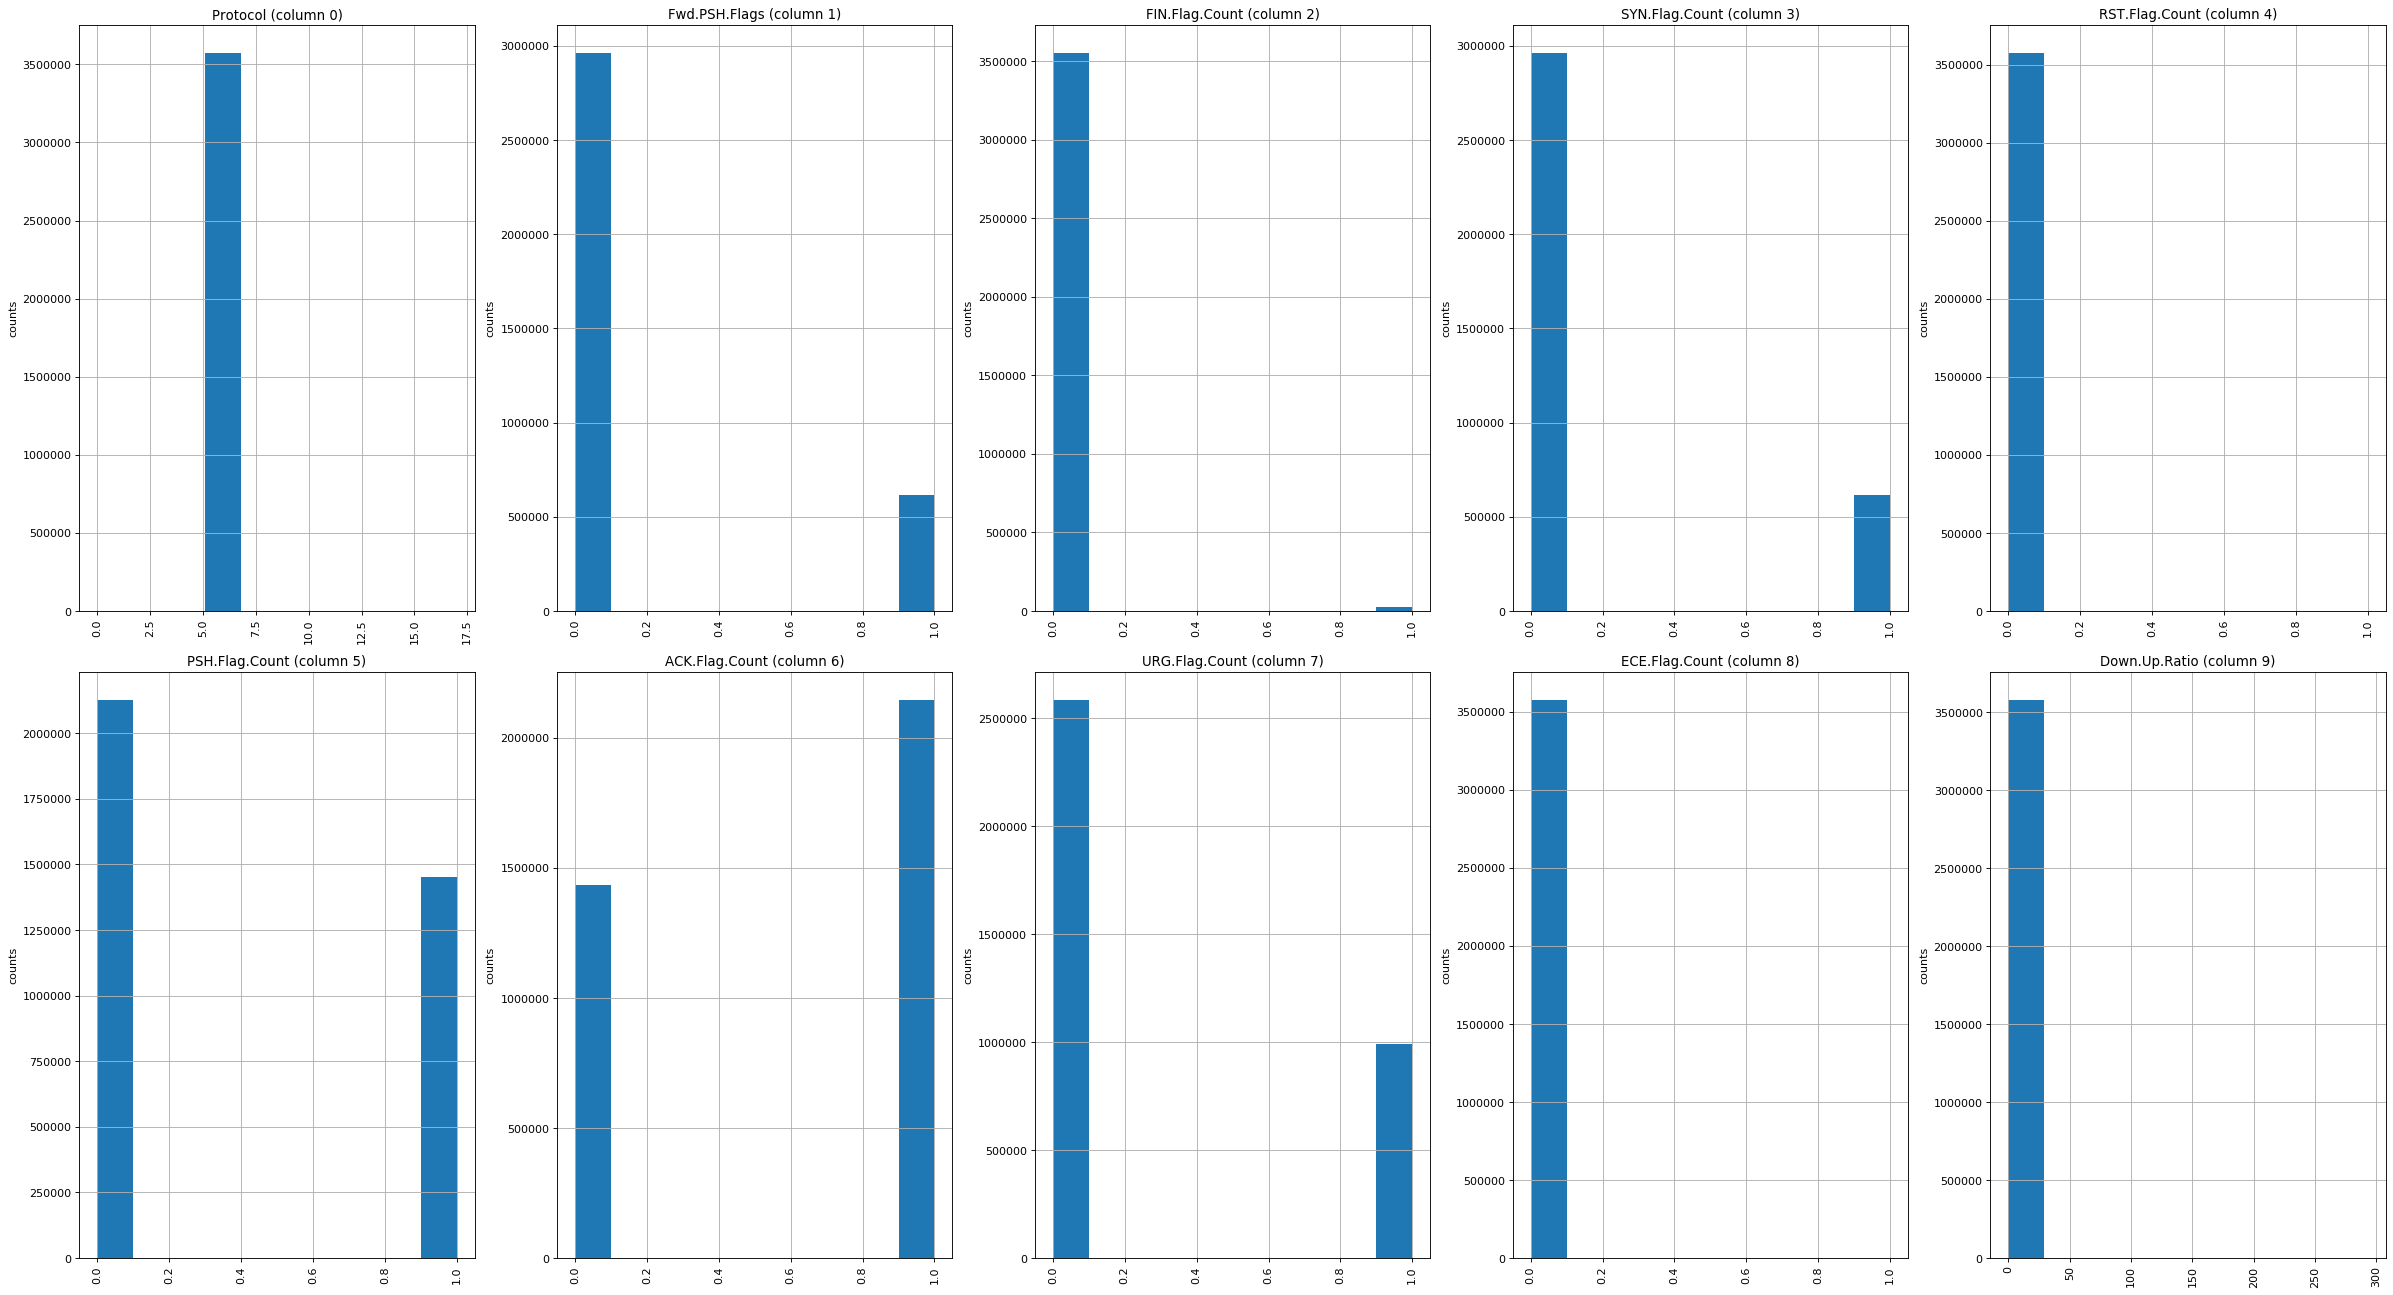

In [ ]:
# Histogram of some columns
def plot_histogram(df, nHistogramShown, nHistogramPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nHistRow = (nCol + nHistogramPerRow - 1) / nHistogramPerRow
    plt.figure(num=None, figsize=(6*nHistogramPerRow, 8*nHistRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nHistogramShown)):
        plt.subplot(nHistRow, nHistogramPerRow, i+1)
        df.iloc[:,i].hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

plot_histogram(df, 10, 5)

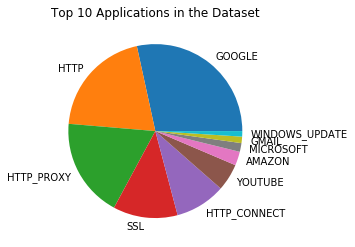

In [ ]:
protocol_name = df['ProtocolName'].value_counts(ascending=False)[:10]
names, count = protocol_name.index.values, protocol_name.values
plt.pie(count, labels=names);
plt.title("Top 10 Applications in the Dataset");

<div dir="rtl">

## <a class="anchor" id="پیش‌پردازش داده‌ها">II. پیش‌پردازش داده‌ها</a>

<div dir="rtl">

جریان‌ها را بر اساس ارتباط تجمیع نمی‌کنیم (شاید در بهبودهای آینده) و هر جریان را جداگانه پردازش می‌کنیم

ستون‌های حذفی - دلیل حذف
* **Flow.ID** - صرفاً یک شناسه ارتباطی است
* **Source.IP** - صرفاً یک شناسه ارتباطی است
* **Source.Port** - پورت‌ها می‌توانند برای شناسایی پروتکل‌ها مفید باشند اما به دلیل باز شدن پورت‌های پویا در سمت کلاینت ممکن است گمراه‌کننده باشند (شاید در بهبودهای آینده)
* **Destination.IP** صرفاً یک شناسه ارتباطی است
* **Destination.Port** - پورت‌ها می‌توانند برای شناسایی پروتکل‌ها مفید باشند اما به دلیل باز شدن پورت‌های پویا در سمت کلاینت ممکن است گمراه‌کننده باشند (شاید در بهبودهای آینده)
* **Timestamp** - در شناسایی جریان‌های منفرد مفید نخواهد بود
* **Label** - فقط حاوی یک مقدار واحد است

In [ ]:
# Drop All unused columns
df_cleaned = df.drop(['Flow.ID','Source.IP', 'Source.Port',
                      'Destination.IP', 'Destination.Port', 'Timestamp',
                      'Label'], axis=1)

In [ ]:
X = df_cleaned.iloc[:,:78]
# we will use 'ProtocolName' after extracting dummy variables
Y = pd.get_dummies(df['ProtocolName'])
X.shape, Y.shape

((3577296, 78), (3577296, 78))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

scale = StandardScaler()

# Standardize features by removing the mean and scaling to unit variance
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2682972, 78), (894324, 78), (2682972, 78), (894324, 78))

<div dir="rtl">

## <a class="anchor" id="مدل‌سازی داده‌ها">III. مدل‌سازی داده‌ها</a>

<div dir="rtl">

از مدل یادگیری عمیق استفاده می‌کنیم زیرا دقت بهتری ارائه می‌دهد. مشکل اکثر الگوریتم‌های یادگیری ماشین عدم پشتیبانی از پردازش دسته‌ای و مصرف زمان زیاد است. با وجود ۳۲ گیگابایت حافظه RAM، بارها با خطای MemoryError و خاتمه فرآیند مواجه شدم. همچنین مدل‌های یادگیری ماشین نیازمند متخصصان حوزه‌ای باتجربه‌تر هستند.

الگوریتم **OneVsRestClassifier(LinearSVC())** امتحان شد که دقت ۴۵٪ داشت

In [ ]:
model = Sequential()

model.add(Dense(512, activation='relu', input_dim=78))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(78, activation='softmax'))

# Note that we use a “softmax” activation
# function in the output layer. This is to ensure
# the output values are in the range of 0 and 1
# and the max will be the predicted class.

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=30, batch_size=128, verbose=2)

Epoch 1/30
 - 130s - loss: 1.5984 - acc: 0.4988
Epoch 2/30
 - 124s - loss: 1.4317 - acc: 0.5519
Epoch 3/30
 - 124s - loss: 1.3718 - acc: 0.5706
Epoch 4/30
 - 124s - loss: 1.3348 - acc: 0.5822
Epoch 5/30
 - 124s - loss: 1.3090 - acc: 0.5899
Epoch 6/30
 - 124s - loss: 1.2880 - acc: 0.5963
Epoch 7/30
 - 124s - loss: 1.2695 - acc: 0.6014
Epoch 8/30
 - 124s - loss: 1.2531 - acc: 0.6064
Epoch 9/30
 - 124s - loss: 1.2388 - acc: 0.6112
Epoch 10/30
 - 123s - loss: 1.2271 - acc: 0.6148
Epoch 11/30
 - 124s - loss: 1.2165 - acc: 0.6184
Epoch 12/30
 - 124s - loss: 1.2071 - acc: 0.6215
Epoch 13/30
 - 124s - loss: 1.1988 - acc: 0.6242
Epoch 14/30
 - 124s - loss: 1.1915 - acc: 0.6262
Epoch 15/30
 - 124s - loss: 1.1843 - acc: 0.6282
Epoch 16/30
 - 125s - loss: 1.1784 - acc: 0.6302
Epoch 17/30
 - 124s - loss: 1.1726 - acc: 0.6318
Epoch 18/30
 - 124s - loss: 1.1672 - acc: 0.6333
Epoch 19/30
 - 124s - loss: 1.1623 - acc: 0.6348
Epoch 20/30
 - 124s - loss: 1.1571 - acc: 0.6362
Epoch 21/30
 - 124s - loss: 1

In [ ]:
model.save('model.h5')

In [ ]:
import joblib
joblib.dump(scale, 'scaler.save')

In [ ]:
import json
label_columns = list(Y.columns)
with open('label_columns.json','w') as f:
    json.dump(label_columns, f)

<div dir="rtl">

## <a class="anchor" id="ارزیابی نتایج">IV. ارزیابی نتایج</a>

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=128)
print(f"\nTest loss {score[0]}, Test accurcy {score[1]}")

894324/894324 [==============================] - 15s 17us/step

Test loss 1.0517627823662645, Test accurcy 0.6631679346653662


In [ ]:
y_preds = model.predict(X_test)
def plot_classification(index):
    pd.Series(y_preds[index], y_test.columns.tolist()).sort_values(ascending=False)[:5].plot(kind='bar');
    plt.title(f"Prediction for {y_test.iloc[index].idxmax()}")

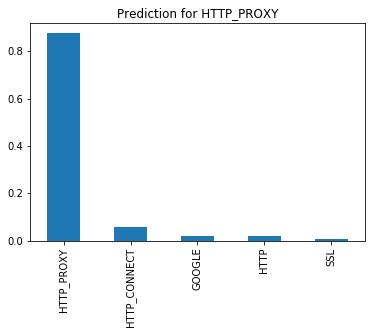

In [ ]:
plot_classification(15)

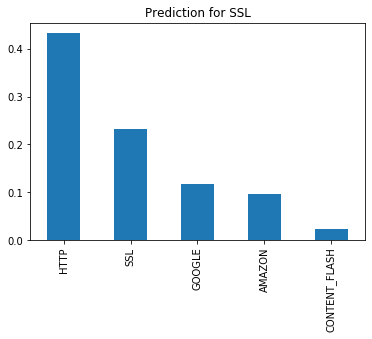

In [ ]:
plot_classification(7)

<div dir="rtl">

در نمونه‌های طبقه‌بندی فوق می‌بینیم که مدل همیشه دقیق نیست و نیاز به بهبود دارد.

یادگیری عمیق عملکرد بهتری داشت احتمالاً به این دلیل که می‌تواند الگوهای عمیق‌تری در داده‌ها شناسایی کند که روش‌های سنتی یادگیری ماشین قادر به تشخیص آن‌ها نبودند.

<div dir="rtl">

## <a class="anchor" id="نتیجه‌گیری">V. نتیجه‌گیری</a>

<div dir="rtl">

این تحلیل نشان می‌دهد که می‌توانیم برنامه جریان‌های IP را با دقت ۶۶٪ در طبقه‌بندی چندکلاسه با ۷۸ کلاس شناسایی کنیم که نتیجه بدی نیست.

مجموعه‌داده حاوی ۳٬۵۷۷٬۲۹۶ رکورد است که آموزش با الگوریتم‌های فاقد قابلیت پردازش دسته‌ای دشوار است.

<div dir="rtl">

### بهبودهای آتی

<div dir="rtl">

می‌توان مدل را با روش‌های زیر ارتقا داد

* استفاده از ویژگی‌های بیشتری که حذف کردیم
* استخراج ویژگی‌های جدید مانند (جریان برای ترافیک ورودی است یا خروجی؟ پورت ممتاز است یا نه؟)
* تجمع جریان‌ها بر اساس ارتباط